In [8]:
%matplotlib inline
import torch
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms

In [9]:
transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                        download=True, transform=transform)

trainloader = torch.utils.data.DataLoader(trainset, batch_size=4,
                                          shuffle=True, num_workers=2)


testset = torchvision.datasets.CIFAR10(root='./data', train=False,
                                       download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=100,
                                         shuffle=False, num_workers=2)

classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')


Files already downloaded and verified
Files already downloaded and verified


 bird  deer truck  deer


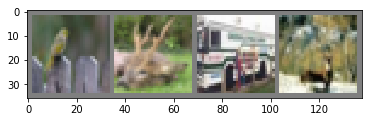

In [10]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join('%5s' % classes[labels[j]] for j in range(4)))


In [11]:
def conv3x3(x,K):
    """3x3 convolution with padding"""
    return F.conv2d(x, K, stride=1, padding=1)

def conv3x3T(x,K):
    """3x3 convolution transpose with padding"""
    #K = torch.transpose(K,0,1)
    return F.conv_transpose2d(x, K, stride=1, padding=1)

def projectTensor(K):
#     shape = K.shape
#     K = K.view(shape[0]*shape[1], shape[2]*shape[3])
#     K = K - K.mean(1).view(-1,1)
#     K = K.view(*shape)
    for i in range(K.shape[0]):
        for j in range(K.shape[1]):        
            K[i,j,:,:] -= K[i,j,:,:].mean()
    return K
        
def projectTorchTensor(K):   
    shape = K.data.shape
    K.data = K.data.view(shape[0]*shape[1], shape[2]*shape[3])
    K.data = K.data - K.data.mean(1).view(-1,1)
    K.data = K.data.view(*shape)
#     for i in range(K.data.shape[0]):
#         for j in range(K.data.shape[1]): 
#             K.data[i,j,:,:] -= K.data[i,j,:,:].mean()
    return K
        
        
dis = nn.CrossEntropyLoss()
def misfit(X,W,C):
    n = W.shape
    X = X.view(-1,n[0])
    S = torch.matmul(X,W)
    return dis(S,C), S   

def getAccuracy(S,labels):
    _, predicted = torch.max(S.data, 1)
    total = labels.size(0)
    correct = (predicted == labels).sum().item()
    return correct/total

In [12]:
# test torch Projection
outChannels = 16 
inChannels = 3
K  = nn.Parameter(torch.Tensor(outChannels, inChannels,3,3))
stdv    = 1e-2
K.data.uniform_(-stdv, stdv)

K = projectTorchTensor(K)
D = K[1,1,:,:]
torch.sum(torch.sum(D,0),0)
print(type(K))

<class 'torch.nn.parameter.Parameter'>


In [13]:
class ResNet(nn.Module):

    def __init__(self, h,NG):
        super().__init__()

        # network geometry
        self.NG       = NG
        # time step
        self.h        = h
        # coarsening and TV norm
        self.coarsen  = nn.AvgPool2d(32)
        self.coarsen2 = nn.AvgPool2d(2)
        
        
    def forward(self,x,Kresnet):
    
        nt = len(Kresnet)
        
        # time stepping
        for j in range(nt):
            
            # First case - rsent style step
            if NG[0,j] == NG[1,j]: 
                #print(torch.norm(z))
                Kresnet[j] = projectTorchTensor( Kresnet[j])
                z  = conv3x3(x, Kresnet[j])
                z  = F.instance_norm(z)
                z  = F.relu(z)        
                z  = conv3x3T(z,Kresnet[j])
                x  = x - self.h*z
            # Change number of channels/resolution    
            else:
                z  = conv3x3(x, Kresnet[j])
                z  = F.instance_norm(z)
                x = F.relu(z)
                if NG[2,j] == 1:
                    x = self.coarsen2(x)
                    
            #q = self.coarsen(x)
            #q = q.view(-1, nc)
            #p = torch.cat((p,q),1)
             
        return x #torch.transpose(p,0,1)

In [14]:
# initialize net and weights
h           = 1e0

# Network geometry
NG = [3,    64,    64,    64,  64,    256,   256,  
      64,   64,    64,    64,  256,   256,   256,
      1,     0,     0,     0,   1,      0,     0]

NG = np.reshape(NG,(3,-1))
net   = ResNet(h,NG)

nsteps = NG.shape[1]


Kresnet = []
for i in range(nsteps):  
    if NG[0,i] == NG[1,i]:
        Ki  = nn.Parameter(torch.Tensor(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]),3,3))
        stdv  = 1e-3
        Ki.data.uniform_(-stdv, stdv)
        Ki   = projectTorchTensor(Ki)
    else:
        Ki = nn.Parameter(torch.Tensor(np.asscalar(NG[1,i]), np.asscalar(NG[0,i]) ,3,3))
        stdv  = 1e-3
        Ki.data.uniform_(-stdv, stdv)
    
    #print(torch.norm(Ki))
    print(type(Ki))
    Kresnet.append(Ki)
    
# weights for linear classifier    
W     = nn.Parameter(torch.Tensor(256*8*8,10))
stdv  = 1e-3
W.data.uniform_(-stdv, stdv)
    


<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>
<class 'torch.nn.parameter.Parameter'>


tensor([[-4.1973e-04,  7.0151e-04,  1.6732e-04,  ..., -9.8503e-04,
          4.1675e-04, -6.8379e-04],
        [ 6.8727e-04, -4.3118e-04,  3.6226e-04,  ...,  9.5677e-04,
          2.2357e-04,  6.5554e-04],
        [-3.8395e-04,  8.2177e-04,  2.4816e-04,  ...,  3.7665e-04,
         -5.1467e-04,  4.7576e-04],
        ...,
        [-8.5824e-04, -9.6840e-05, -3.8730e-04,  ..., -7.9879e-04,
         -3.5814e-04,  7.3230e-04],
        [-4.2054e-04, -7.3087e-04,  3.9068e-04,  ...,  5.7438e-04,
         -8.6402e-04, -9.0369e-04],
        [-3.3383e-04, -4.9431e-04, -1.4177e-04,  ..., -5.2488e-05,
          7.0341e-04,  3.4138e-04]])

In [15]:
# run the network
x = net(images,Kresnet)
C = torch.randint(0,10,(4,),dtype=torch.long)

loss,_ = misfit(x,W,C)
print(loss)    


tensor(2.2994)


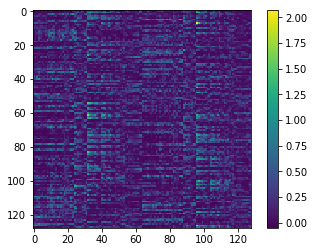

In [16]:
xnp = x.data.numpy()
xnp = np.reshape(xnp,(4,16*8,16*8))
im = plt.imshow(xnp[1,:,:])
plt.colorbar(im)

In [17]:
import torch.optim as optim
optimizer = optim.SGD([{'params':Kresnet},{'params': W}], lr=1e-4, momentum=0)


In [18]:
for epoch in range(2):  # loop over the dataset multiple times

    running_loss = 0.0
    running_accuracy = 0.0
    for i, data in enumerate(trainloader, 0):
        # get the inputs
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        x    = net(inputs,Kresnet)
        loss, Si = misfit(x,W,labels)
        loss.backward()
             
        optimizer.step()

        # print statistics
        accuracy = getAccuracy(Si,labels)
        running_loss     += loss.item()
        running_accuracy += accuracy
        if i % 200 == 199:    # print every 2000 mini-batches
            # compute validation accuracy
            with torch.no_grad():
                #for data in testloader:
                dataiter = iter(testloader)
                imagesV, labelsV = dataiter.next()
                xV = net(imagesV,Kresnet)
                lossV, SiV = misfit(xV,W,labelsV)
                accuracyV  = getAccuracy(SiV,labelsV)

            
            print('[%d, %5d]  %.3f  %.3f  %.3f' %
                  (epoch + 1, i + 1, running_loss / 200, running_accuracy/200, accuracyV))
            running_loss = 0.0
            running_accuracy = 0.0

print('Finished Training')

[1,   200]  2.201  0.185  0.280
[1,   400]  2.107  0.250  0.320
[1,   600]  2.038  0.282  0.390


Process Process-4:
Traceback (most recent call last):
Process Process-3:
Process Process-9:
Process Process-10:
Traceback (most recent call last):
Traceback (most recent call last):
Traceback (most recent call last):
  File "/home/justin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/justin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/justin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/justin/anaconda3/lib/python3.6/multiprocessing/process.py", line 258, in _bootstrap
    self.run()
  File "/home/justin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/justin/anaconda3/lib/python3.6/multiprocessing/process.py", line 93, in run
    self._target(*self._args, **self._kwargs)
  File "/home/justin/anaconda3/lib/python3.6/multiprocessin

Traceback (most recent call last):
  File "/home/justin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 2910, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-18-0726a48a06ad>", line 13, in <module>
    x    = net(inputs,Kresnet)
  File "/home/justin/anaconda3/lib/python3.6/site-packages/torch/nn/modules/module.py", line 491, in __call__
    result = self.forward(*input, **kwargs)
  File "<ipython-input-13-f454f097512b>", line 26, in forward
    z  = conv3x3(x, Kresnet[j])
  File "<ipython-input-11-9bb6892dec05>", line 3, in conv3x3
    return F.conv2d(x, K, stride=1, padding=1)
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/justin/anaconda3/lib/python3.6/site-packages/IPython/core/interactiveshell.py", line 1828, in showtraceback
    stb = value._render_traceback_()
AttributeError: 'KeyboardInterrupt' object has no attribute '_

KeyboardInterrupt: 